Cell 1: Setup and Data Directories

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import copy

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


Cell 2: Get Class Names and Dataset Information

In [2]:
# Data directories
data_dir = '/kaggle/input/animaldataset/animalDataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
# Get class names from train directory
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 10
Class names: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


Cell 3: Data Transforms

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Cell 4: Create Datasets and DataLoaders

In [4]:
# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(f"Dataset sizes: {dataset_sizes}")

Dataset sizes: {'train': 18322, 'val': 3926, 'test': 3931}


Cell 5: Model Setup

In [5]:
# Load pretrained ResNet50 with updated syntax
from torchvision.models import ResNet50_Weights

# Load with weights and updated API
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


Model Summary Cell

In [6]:
# Model Summary
from torchsummary import summary

print("\nResNet50 Model Summary:")
print(f"Input size: (3, 224, 224)")
print(f"Number of classes: {num_classes}\n")

# Temporarily move model to CPU for summary
model_to_summarize = model.to('cpu')
summary(model_to_summarize, input_size=(3, 224, 224), device='cpu')

# Move model back to original device
model = model.to(device)

# Parameter count breakdown
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


ResNet50 Model Summary:
Input size: (3, 224, 224)
Number of classes: 10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13         

Cell 6: Training Function

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track losses and accuracies for plotting
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model and history for plotting
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    }
    
    return model, history

Cell 7: Train the Model

In [8]:
# Train the model
num_epochs = 15
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.6618 Acc: 0.7973
val Loss: 0.1456 Acc: 0.9615

Epoch 1/14
----------
train Loss: 0.5150 Acc: 0.8315
val Loss: 0.1541 Acc: 0.9524

Epoch 2/14
----------
train Loss: 0.4988 Acc: 0.8369
val Loss: 0.1340 Acc: 0.9605

Epoch 3/14
----------
train Loss: 0.4829 Acc: 0.8441
val Loss: 0.1365 Acc: 0.9592

Epoch 4/14
----------
train Loss: 0.4844 Acc: 0.8411
val Loss: 0.1359 Acc: 0.9628

Epoch 5/14
----------
train Loss: 0.4718 Acc: 0.8448
val Loss: 0.1542 Acc: 0.9564

Epoch 6/14
----------
train Loss: 0.4718 Acc: 0.8466
val Loss: 0.1560 Acc: 0.9547

Epoch 7/14
----------
train Loss: 0.4228 Acc: 0.8584
val Loss: 0.1226 Acc: 0.9641

Epoch 8/14
----------
train Loss: 0.4165 Acc: 0.8613
val Loss: 0.1212 Acc: 0.9646

Epoch 9/14
----------
train Loss: 0.4173 Acc: 0.8600
val Loss: 0.1164 Acc: 0.9659

Epoch 10/14
----------
train Loss: 0.4210 Acc: 0.8637
val Loss: 0.1212 Acc: 0.9646

Epoch 11/14
----------
train Loss: 0.4214 Acc: 0.8613
val Loss: 0.1165 Acc: 0.9656

Ep

Cell 8: Plot Training History

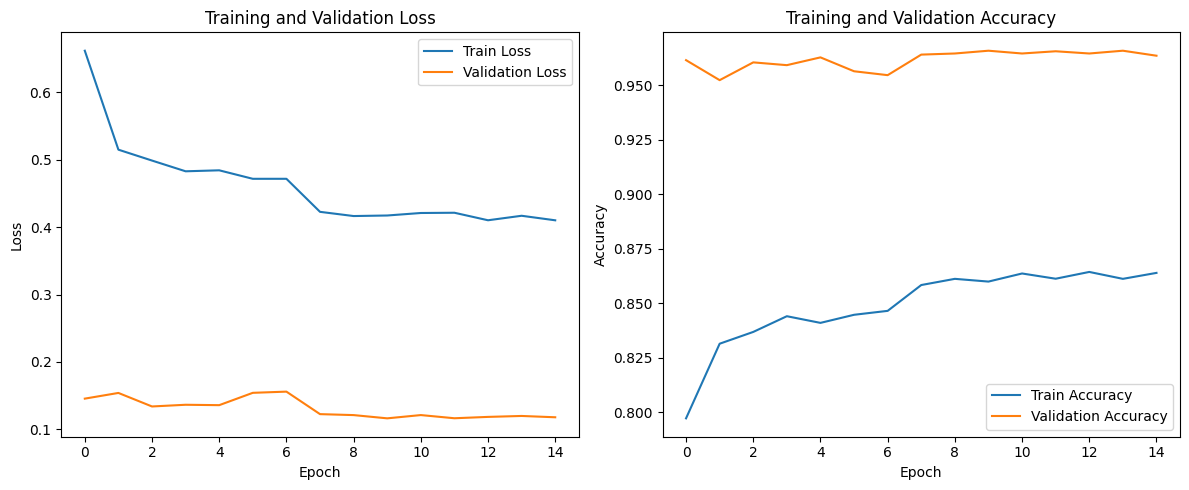

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Cell 9: Evaluation Function

In [10]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

Cell 10: Test Evaluation

In [11]:
test_preds, test_labels = evaluate_model(model, dataloaders['test'])

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.96      0.97      0.96       317
         cat       0.98      0.97      0.98       251
     chicken       0.97      0.98      0.98       465
         cow       0.96      0.91      0.93       280
         dog       0.97      0.97      0.97       730
    elephant       1.00      0.98      0.99       217
       horse       0.93      0.97      0.95       394
       sheep       0.94      0.97      0.95       273
      spider       0.99      0.98      0.99       724
    squirrel       0.98      0.97      0.97       280

    accuracy                           0.97      3931
   macro avg       0.97      0.97      0.97      3931
weighted avg       0.97      0.97      0.97      3931



Cell 11: Confusion Matrix

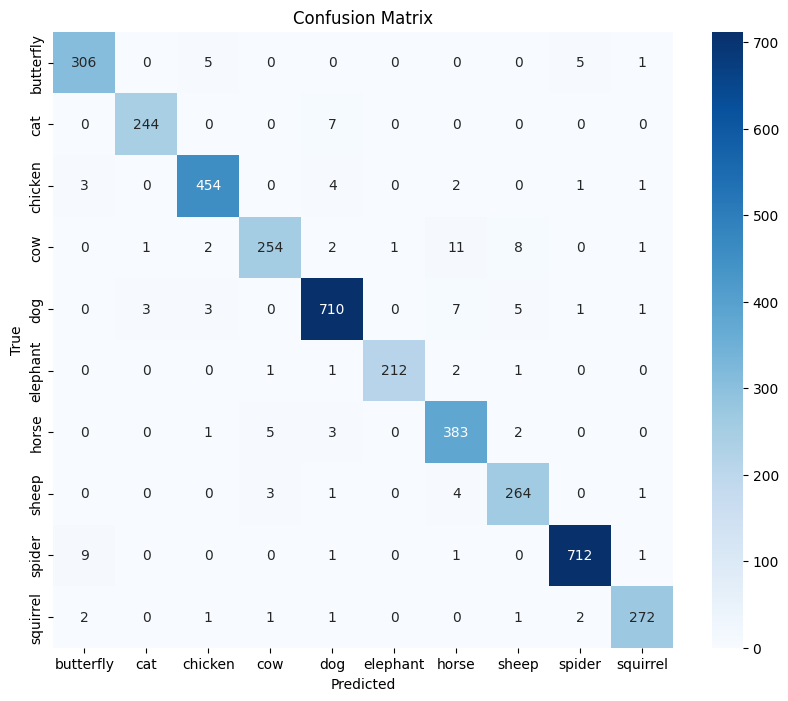

In [12]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Cell 12: Visualization Functions

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

Cell 13: Visualize Predictions

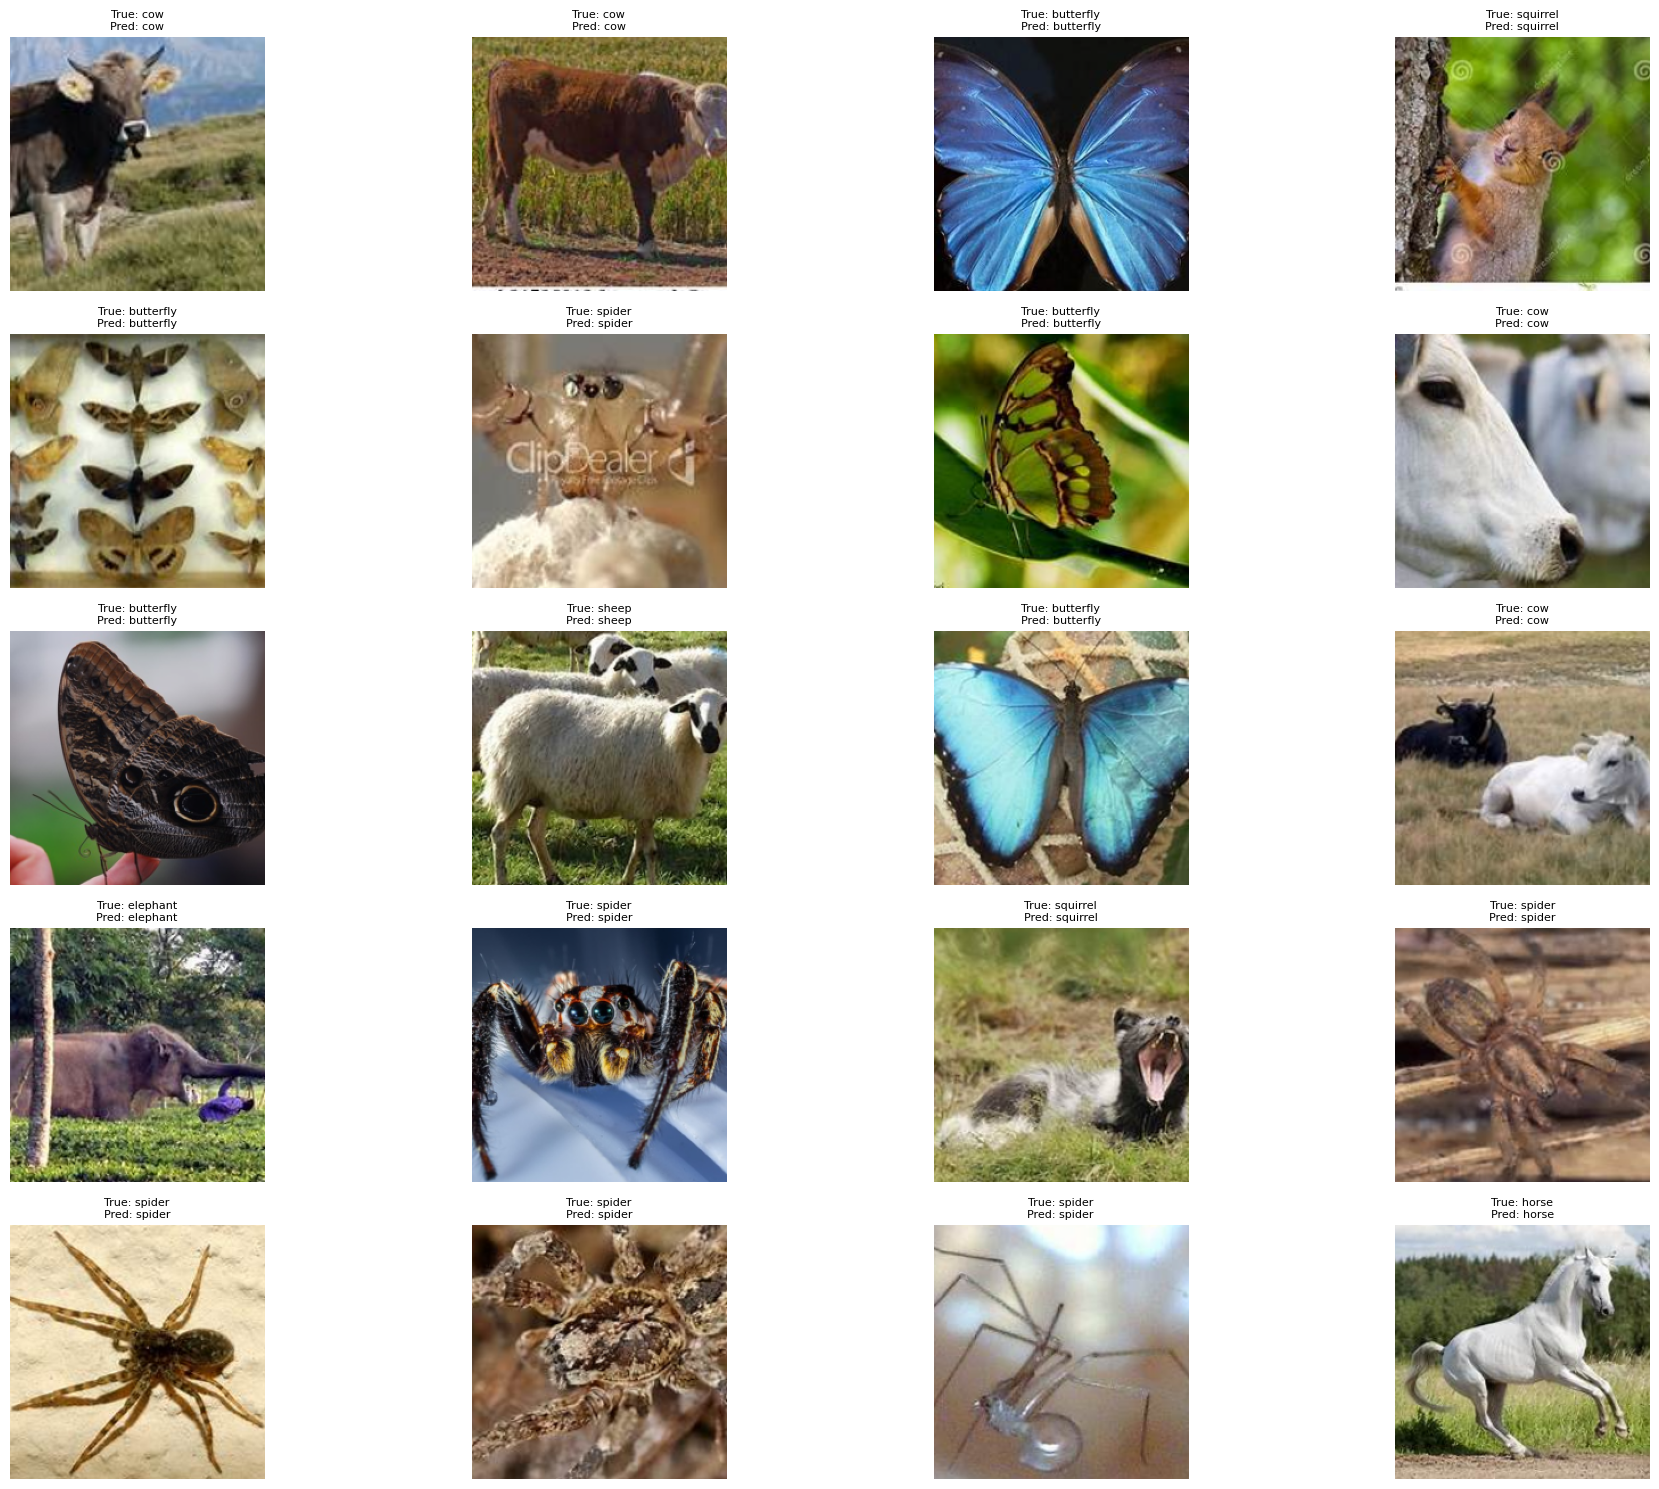

In [14]:
# Create a shuffled test loader just for visualization
shuffled_test_loader = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=batch_size,
    shuffle=True,  # This ensures we get random samples
    num_workers=4
)

# Get a random batch of test data
inputs, classes = next(iter(shuffled_test_loader))

# Make predictions
model.eval()
with torch.no_grad():
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Plot images with predictions
plt.figure(figsize=(20, 15))
for i in range(min(20, len(inputs))):  # Show up to 20 images
    plt.subplot(5, 4, i+1)
    imshow(inputs.cpu()[i])
    plt.title(f'True: {class_names[classes[i]]}\nPred: {class_names[preds[i]]}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

Cell 14: Save the Model

In [15]:
# Save the model
torch.save(model.state_dict(), 'resnet50_animal_classifier.pth')
print("Model saved as 'resnet50_animal_classifier.pth'")

Model saved as 'resnet50_animal_classifier.pth'
